# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, hidden4_size),
            nn.GELU(),
            nn.Linear(hidden4_size, hidden5_size),
            nn.GELU(),
            nn.Linear(hidden5_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=200, out_features=200, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 0.8666
Epoch 1/200, Iteration 2/12, Loss: 1.0961
Epoch 1/200, Iteration 3/12, Loss: 0.5424
Epoch 1/200, Iteration 4/12, Loss: 0.6023
Epoch 1/200, Iteration 5/12, Loss: 0.4318
Epoch 1/200, Iteration 6/12, Loss: 0.5661
Epoch 1/200, Iteration 7/12, Loss: 0.5476
Epoch 1/200, Iteration 8/12, Loss: 0.4208
Epoch 1/200, Iteration 9/12, Loss: 0.2690
Epoch 1/200, Iteration 10/12, Loss: 0.1854
Epoch 1/200, Iteration 11/12, Loss: 0.3609
Epoch 1/200, Iteration 12/12, Loss: 0.1100
Epoch 1/200, Iteration 13/12, Loss: 0.2036
Train Error: 
 Accuracy: 64.88%, Avg loss: 0.181780, MRE: 0.238041, MAE: 0.041951 

Test Error: 
 Accuracy: 66.5%, Avg loss: 0.170250, MRE: 0.202609, MAE: 0.037899 

Epoch 2/200, Iteration 1/12, Loss: 0.2150
Epoch 2/200, Iteration 2/12, Loss: 0.1063
Epoch 2/200, Iteration 3/12, Loss: 0.1674
Epoch 2/200, Iteration 4/12, Loss: 0.1423
Epoch 2/200, Iteration 5/12, Loss: 0.1170
Epoch 2/200, Iteration 6/12, Loss: 0.1037
Epoch 2/200, Iteration 7/12, Los

Epoch 12/200, Iteration 12/12, Loss: 0.0013
Epoch 12/200, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.001931, MRE: 0.023134, MAE: 0.005117 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002317, MRE: 0.023220, MAE: 0.005525 

Epoch 13/200, Iteration 1/12, Loss: 0.0021
Epoch 13/200, Iteration 2/12, Loss: 0.0011
Epoch 13/200, Iteration 3/12, Loss: 0.0016
Epoch 13/200, Iteration 4/12, Loss: 0.0011
Epoch 13/200, Iteration 5/12, Loss: 0.0016
Epoch 13/200, Iteration 6/12, Loss: 0.0008
Epoch 13/200, Iteration 7/12, Loss: 0.0007
Epoch 13/200, Iteration 8/12, Loss: 0.0014
Epoch 13/200, Iteration 9/12, Loss: 0.0011
Epoch 13/200, Iteration 10/12, Loss: 0.0010
Epoch 13/200, Iteration 11/12, Loss: 0.0012
Epoch 13/200, Iteration 12/12, Loss: 0.0004
Epoch 13/200, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000797, MRE: 0.014784, MAE: 0.002669 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000711, MRE: 0.011174, MAE: 0.002581 

Epoch 14/200, Ite

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.004174, MRE: 0.027253, MAE: 0.006353 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003722, MRE: 0.025308, MAE: 0.006260 

Epoch 25/200, Iteration 1/12, Loss: 0.0040
Epoch 25/200, Iteration 2/12, Loss: 0.0030
Epoch 25/200, Iteration 3/12, Loss: 0.0052
Epoch 25/200, Iteration 4/12, Loss: 0.0023
Epoch 25/200, Iteration 5/12, Loss: 0.0042
Epoch 25/200, Iteration 6/12, Loss: 0.0023
Epoch 25/200, Iteration 7/12, Loss: 0.0033
Epoch 25/200, Iteration 8/12, Loss: 0.0011
Epoch 25/200, Iteration 9/12, Loss: 0.0022
Epoch 25/200, Iteration 10/12, Loss: 0.0011
Epoch 25/200, Iteration 11/12, Loss: 0.0010
Epoch 25/200, Iteration 12/12, Loss: 0.0008
Epoch 25/200, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000886, MRE: 0.017608, MAE: 0.003079 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000943, MRE: 0.018055, MAE: 0.003144 

Epoch 26/200, Iteration 1/12, Loss: 0.0009
Epoch 26/200, Iteration 2/12, Loss: 0.0009
Epoch 26/200, Iter

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000184, MRE: 0.007766, MAE: 0.001222 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000185, MRE: 0.005891, MAE: 0.001288 

Epoch 37/200, Iteration 1/12, Loss: 0.0004
Epoch 37/200, Iteration 2/12, Loss: 0.0002
Epoch 37/200, Iteration 3/12, Loss: 0.0001
Epoch 37/200, Iteration 4/12, Loss: 0.0002
Epoch 37/200, Iteration 5/12, Loss: 0.0002
Epoch 37/200, Iteration 6/12, Loss: 0.0002
Epoch 37/200, Iteration 7/12, Loss: 0.0002
Epoch 37/200, Iteration 8/12, Loss: 0.0001
Epoch 37/200, Iteration 9/12, Loss: 0.0001
Epoch 37/200, Iteration 10/12, Loss: 0.0003
Epoch 37/200, Iteration 11/12, Loss: 0.0002
Epoch 37/200, Iteration 12/12, Loss: 0.0002
Epoch 37/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000206, MRE: 0.008271, MAE: 0.001291 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000174, MRE: 0.005781, MAE: 0.001299 

Epoch 38/200, Iteration 1/12, Loss: 0.0001
Epoch 38/200, Iteration 2/12, Loss: 0.0002
Epoch 38/200, Ite

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000145, MRE: 0.007069, MAE: 0.001101 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000123, MRE: 0.004918, MAE: 0.001109 

Epoch 49/200, Iteration 1/12, Loss: 0.0001
Epoch 49/200, Iteration 2/12, Loss: 0.0002
Epoch 49/200, Iteration 3/12, Loss: 0.0001
Epoch 49/200, Iteration 4/12, Loss: 0.0003
Epoch 49/200, Iteration 5/12, Loss: 0.0001
Epoch 49/200, Iteration 6/12, Loss: 0.0001
Epoch 49/200, Iteration 7/12, Loss: 0.0002
Epoch 49/200, Iteration 8/12, Loss: 0.0001
Epoch 49/200, Iteration 9/12, Loss: 0.0001
Epoch 49/200, Iteration 10/12, Loss: 0.0002
Epoch 49/200, Iteration 11/12, Loss: 0.0001
Epoch 49/200, Iteration 12/12, Loss: 0.0001
Epoch 49/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.006933, MAE: 0.001010 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000142, MRE: 0.005424, MAE: 0.001126 

Epoch 50/200, Iteration 1/12, Loss: 0.0002
Epoch 50/200, Iteration 2/12, Loss: 0.0001
Epoch 50/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000123, MRE: 0.006370, MAE: 0.000984 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000130, MRE: 0.004770, MAE: 0.001045 

Epoch 61/200, Iteration 1/12, Loss: 0.0001
Epoch 61/200, Iteration 2/12, Loss: 0.0001
Epoch 61/200, Iteration 3/12, Loss: 0.0001
Epoch 61/200, Iteration 4/12, Loss: 0.0001
Epoch 61/200, Iteration 5/12, Loss: 0.0001
Epoch 61/200, Iteration 6/12, Loss: 0.0001
Epoch 61/200, Iteration 7/12, Loss: 0.0002
Epoch 61/200, Iteration 8/12, Loss: 0.0001
Epoch 61/200, Iteration 9/12, Loss: 0.0002
Epoch 61/200, Iteration 10/12, Loss: 0.0001
Epoch 61/200, Iteration 11/12, Loss: 0.0001
Epoch 61/200, Iteration 12/12, Loss: 0.0001
Epoch 61/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000158, MRE: 0.007002, MAE: 0.001096 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000166, MRE: 0.005535, MAE: 0.001166 

Epoch 62/200, Iteration 1/12, Loss: 0.0002
Epoch 62/200, Iteration 2/12, Loss: 0.0001
Epoch 62/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000080, MRE: 0.005973, MAE: 0.000836 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000088, MRE: 0.004512, MAE: 0.000939 

Epoch 73/200, Iteration 1/12, Loss: 0.0001
Epoch 73/200, Iteration 2/12, Loss: 0.0001
Epoch 73/200, Iteration 3/12, Loss: 0.0001
Epoch 73/200, Iteration 4/12, Loss: 0.0001
Epoch 73/200, Iteration 5/12, Loss: 0.0000
Epoch 73/200, Iteration 6/12, Loss: 0.0001
Epoch 73/200, Iteration 7/12, Loss: 0.0001
Epoch 73/200, Iteration 8/12, Loss: 0.0001
Epoch 73/200, Iteration 9/12, Loss: 0.0001
Epoch 73/200, Iteration 10/12, Loss: 0.0001
Epoch 73/200, Iteration 11/12, Loss: 0.0001
Epoch 73/200, Iteration 12/12, Loss: 0.0001
Epoch 73/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000082, MRE: 0.005703, MAE: 0.000839 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000096, MRE: 0.004466, MAE: 0.000952 

Epoch 74/200, Iteration 1/12, Loss: 0.0001
Epoch 74/200, Iteration 2/12, Loss: 0.0001
Epoch 74/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000084, MRE: 0.005404, MAE: 0.000841 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000067, MRE: 0.003697, MAE: 0.000858 

Epoch 85/200, Iteration 1/12, Loss: 0.0001
Epoch 85/200, Iteration 2/12, Loss: 0.0001
Epoch 85/200, Iteration 3/12, Loss: 0.0001
Epoch 85/200, Iteration 4/12, Loss: 0.0001
Epoch 85/200, Iteration 5/12, Loss: 0.0001
Epoch 85/200, Iteration 6/12, Loss: 0.0001
Epoch 85/200, Iteration 7/12, Loss: 0.0001
Epoch 85/200, Iteration 8/12, Loss: 0.0001
Epoch 85/200, Iteration 9/12, Loss: 0.0001
Epoch 85/200, Iteration 10/12, Loss: 0.0001
Epoch 85/200, Iteration 11/12, Loss: 0.0001
Epoch 85/200, Iteration 12/12, Loss: 0.0000
Epoch 85/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000072, MRE: 0.005435, MAE: 0.000775 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000070, MRE: 0.003678, MAE: 0.000807 

Epoch 86/200, Iteration 1/12, Loss: 0.0001
Epoch 86/200, Iteration 2/12, Loss: 0.0000
Epoch 86/200, Ite

Epoch 96/200, Iteration 10/12, Loss: 0.0000
Epoch 96/200, Iteration 11/12, Loss: 0.0000
Epoch 96/200, Iteration 12/12, Loss: 0.0001
Epoch 96/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000062, MRE: 0.005007, MAE: 0.000724 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000057, MRE: 0.003360, MAE: 0.000770 

Epoch 97/200, Iteration 1/12, Loss: 0.0001
Epoch 97/200, Iteration 2/12, Loss: 0.0000
Epoch 97/200, Iteration 3/12, Loss: 0.0001
Epoch 97/200, Iteration 4/12, Loss: 0.0000
Epoch 97/200, Iteration 5/12, Loss: 0.0001
Epoch 97/200, Iteration 6/12, Loss: 0.0001
Epoch 97/200, Iteration 7/12, Loss: 0.0001
Epoch 97/200, Iteration 8/12, Loss: 0.0001
Epoch 97/200, Iteration 9/12, Loss: 0.0000
Epoch 97/200, Iteration 10/12, Loss: 0.0001
Epoch 97/200, Iteration 11/12, Loss: 0.0001
Epoch 97/200, Iteration 12/12, Loss: 0.0001
Epoch 97/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000060, MRE: 0.004901, MAE: 0.000716 

Test Error

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000050, MRE: 0.004871, MAE: 0.000678 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000059, MRE: 0.003454, MAE: 0.000758 

Epoch 108/200, Iteration 1/12, Loss: 0.0000
Epoch 108/200, Iteration 2/12, Loss: 0.0000
Epoch 108/200, Iteration 3/12, Loss: 0.0001
Epoch 108/200, Iteration 4/12, Loss: 0.0000
Epoch 108/200, Iteration 5/12, Loss: 0.0001
Epoch 108/200, Iteration 6/12, Loss: 0.0000
Epoch 108/200, Iteration 7/12, Loss: 0.0001
Epoch 108/200, Iteration 8/12, Loss: 0.0000
Epoch 108/200, Iteration 9/12, Loss: 0.0000
Epoch 108/200, Iteration 10/12, Loss: 0.0001
Epoch 108/200, Iteration 11/12, Loss: 0.0001
Epoch 108/200, Iteration 12/12, Loss: 0.0000
Epoch 108/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000067, MRE: 0.004696, MAE: 0.000725 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000055, MRE: 0.003526, MAE: 0.000788 

Epoch 109/200, Iteration 1/12, Loss: 0.0001
Epoch 109/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000050, MRE: 0.004774, MAE: 0.000712 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000060, MRE: 0.003718, MAE: 0.000804 

Epoch 120/200, Iteration 1/12, Loss: 0.0001
Epoch 120/200, Iteration 2/12, Loss: 0.0000
Epoch 120/200, Iteration 3/12, Loss: 0.0001
Epoch 120/200, Iteration 4/12, Loss: 0.0001
Epoch 120/200, Iteration 5/12, Loss: 0.0001
Epoch 120/200, Iteration 6/12, Loss: 0.0000
Epoch 120/200, Iteration 7/12, Loss: 0.0000
Epoch 120/200, Iteration 8/12, Loss: 0.0001
Epoch 120/200, Iteration 9/12, Loss: 0.0000
Epoch 120/200, Iteration 10/12, Loss: 0.0001
Epoch 120/200, Iteration 11/12, Loss: 0.0000
Epoch 120/200, Iteration 12/12, Loss: 0.0000
Epoch 120/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000039, MRE: 0.004264, MAE: 0.000586 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000044, MRE: 0.003091, MAE: 0.000666 

Epoch 121/200, Iteration 1/12, Loss: 0.0000
Epoch 121/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.005711, MAE: 0.001117 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000147, MRE: 0.005314, MAE: 0.001323 

Epoch 132/200, Iteration 1/12, Loss: 0.0001
Epoch 132/200, Iteration 2/12, Loss: 0.0001
Epoch 132/200, Iteration 3/12, Loss: 0.0001
Epoch 132/200, Iteration 4/12, Loss: 0.0001
Epoch 132/200, Iteration 5/12, Loss: 0.0001
Epoch 132/200, Iteration 6/12, Loss: 0.0001
Epoch 132/200, Iteration 7/12, Loss: 0.0000
Epoch 132/200, Iteration 8/12, Loss: 0.0001
Epoch 132/200, Iteration 9/12, Loss: 0.0001
Epoch 132/200, Iteration 10/12, Loss: 0.0000
Epoch 132/200, Iteration 11/12, Loss: 0.0001
Epoch 132/200, Iteration 12/12, Loss: 0.0000
Epoch 132/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000057, MRE: 0.004449, MAE: 0.000710 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000053, MRE: 0.003178, MAE: 0.000767 

Epoch 133/200, Iteration 1/12, Loss: 0.0000
Epoch 133/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.003789, MAE: 0.000531 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000039, MRE: 0.002976, MAE: 0.000637 

Epoch 144/200, Iteration 1/12, Loss: 0.0000
Epoch 144/200, Iteration 2/12, Loss: 0.0000
Epoch 144/200, Iteration 3/12, Loss: 0.0000
Epoch 144/200, Iteration 4/12, Loss: 0.0000
Epoch 144/200, Iteration 5/12, Loss: 0.0001
Epoch 144/200, Iteration 6/12, Loss: 0.0000
Epoch 144/200, Iteration 7/12, Loss: 0.0000
Epoch 144/200, Iteration 8/12, Loss: 0.0000
Epoch 144/200, Iteration 9/12, Loss: 0.0000
Epoch 144/200, Iteration 10/12, Loss: 0.0000
Epoch 144/200, Iteration 11/12, Loss: 0.0000
Epoch 144/200, Iteration 12/12, Loss: 0.0000
Epoch 144/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000036, MRE: 0.004024, MAE: 0.000562 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000046, MRE: 0.002909, MAE: 0.000680 

Epoch 145/200, Iteration 1/12, Loss: 0.0000
Epoch 145/200, Iteration 2/12, Loss: 0.0000
Ep

Epoch 155/200, Iteration 12/12, Loss: 0.0000
Epoch 155/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000041, MRE: 0.004082, MAE: 0.000651 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000056, MRE: 0.003386, MAE: 0.000775 

Epoch 156/200, Iteration 1/12, Loss: 0.0000
Epoch 156/200, Iteration 2/12, Loss: 0.0000
Epoch 156/200, Iteration 3/12, Loss: 0.0000
Epoch 156/200, Iteration 4/12, Loss: 0.0001
Epoch 156/200, Iteration 5/12, Loss: 0.0000
Epoch 156/200, Iteration 6/12, Loss: 0.0000
Epoch 156/200, Iteration 7/12, Loss: 0.0001
Epoch 156/200, Iteration 8/12, Loss: 0.0001
Epoch 156/200, Iteration 9/12, Loss: 0.0000
Epoch 156/200, Iteration 10/12, Loss: 0.0000
Epoch 156/200, Iteration 11/12, Loss: 0.0000
Epoch 156/200, Iteration 12/12, Loss: 0.0000
Epoch 156/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000037, MRE: 0.004094, MAE: 0.000578 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000048, MRE: 0.003554, MAE: 0.000708 



Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000036, MRE: 0.003709, MAE: 0.000542 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000039, MRE: 0.003005, MAE: 0.000619 

Epoch 167/200, Iteration 1/12, Loss: 0.0000
Epoch 167/200, Iteration 2/12, Loss: 0.0001
Epoch 167/200, Iteration 3/12, Loss: 0.0000
Epoch 167/200, Iteration 4/12, Loss: 0.0000
Epoch 167/200, Iteration 5/12, Loss: 0.0001
Epoch 167/200, Iteration 6/12, Loss: 0.0000
Epoch 167/200, Iteration 7/12, Loss: 0.0000
Epoch 167/200, Iteration 8/12, Loss: 0.0000
Epoch 167/200, Iteration 9/12, Loss: 0.0001
Epoch 167/200, Iteration 10/12, Loss: 0.0000
Epoch 167/200, Iteration 11/12, Loss: 0.0000
Epoch 167/200, Iteration 12/12, Loss: 0.0000
Epoch 167/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000029, MRE: 0.003703, MAE: 0.000561 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000035, MRE: 0.002891, MAE: 0.000627 

Epoch 168/200, Iteration 1/12, Loss: 0.0000
Epoch 168/200, Iteration 2/12, Loss: 0.0001
Ep

Epoch 178/200, Iteration 9/12, Loss: 0.0001
Epoch 178/200, Iteration 10/12, Loss: 0.0000
Epoch 178/200, Iteration 11/12, Loss: 0.0000
Epoch 178/200, Iteration 12/12, Loss: 0.0000
Epoch 178/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.003398, MAE: 0.000462 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.002612, MAE: 0.000552 

Epoch 179/200, Iteration 1/12, Loss: 0.0000
Epoch 179/200, Iteration 2/12, Loss: 0.0000
Epoch 179/200, Iteration 3/12, Loss: 0.0000
Epoch 179/200, Iteration 4/12, Loss: 0.0000
Epoch 179/200, Iteration 5/12, Loss: 0.0000
Epoch 179/200, Iteration 6/12, Loss: 0.0000
Epoch 179/200, Iteration 7/12, Loss: 0.0000
Epoch 179/200, Iteration 8/12, Loss: 0.0000
Epoch 179/200, Iteration 9/12, Loss: 0.0000
Epoch 179/200, Iteration 10/12, Loss: 0.0000
Epoch 179/200, Iteration 11/12, Loss: 0.0000
Epoch 179/200, Iteration 12/12, Loss: 0.0000
Epoch 179/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, 

Epoch 189/200, Iteration 10/12, Loss: 0.0000
Epoch 189/200, Iteration 11/12, Loss: 0.0000
Epoch 189/200, Iteration 12/12, Loss: 0.0001
Epoch 189/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000030, MRE: 0.004829, MAE: 0.000511 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000041, MRE: 0.002724, MAE: 0.000606 

Epoch 190/200, Iteration 1/12, Loss: 0.0000
Epoch 190/200, Iteration 2/12, Loss: 0.0000
Epoch 190/200, Iteration 3/12, Loss: 0.0000
Epoch 190/200, Iteration 4/12, Loss: 0.0000
Epoch 190/200, Iteration 5/12, Loss: 0.0000
Epoch 190/200, Iteration 6/12, Loss: 0.0000
Epoch 190/200, Iteration 7/12, Loss: 0.0000
Epoch 190/200, Iteration 8/12, Loss: 0.0000
Epoch 190/200, Iteration 9/12, Loss: 0.0000
Epoch 190/200, Iteration 10/12, Loss: 0.0000
Epoch 190/200, Iteration 11/12, Loss: 0.0000
Epoch 190/200, Iteration 12/12, Loss: 0.0000
Epoch 190/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000034, MRE: 0.004040, MAE: 0.00

Epoch 200/200, Iteration 12/12, Loss: 0.0000
Epoch 200/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000016, MRE: 0.002934, MAE: 0.000383 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.002344, MAE: 0.000483 

Training time: 115.5625 s


#### Plots loss vs Epoch

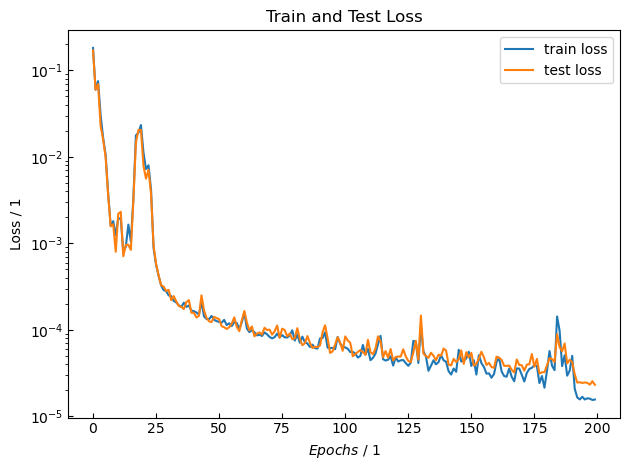

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999878350600376 , R^2(NH3) = 0.9999804328385546
Test Dataset: R^2(H2) = 0.9999766767700327 , R^2(NH3) = 0.999975286922851
Max Error Training: |x_H2 - x_H2,pred| = 0.0038193020109230646 , |x_NH3 - x_NH3,pred| = 0.003074978484306712
Max Error Test: |x_H2 - x_H2,pred| = 0.0029932127564339384 , |x_NH3 - x_NH3,pred| = 0.003017454570908712


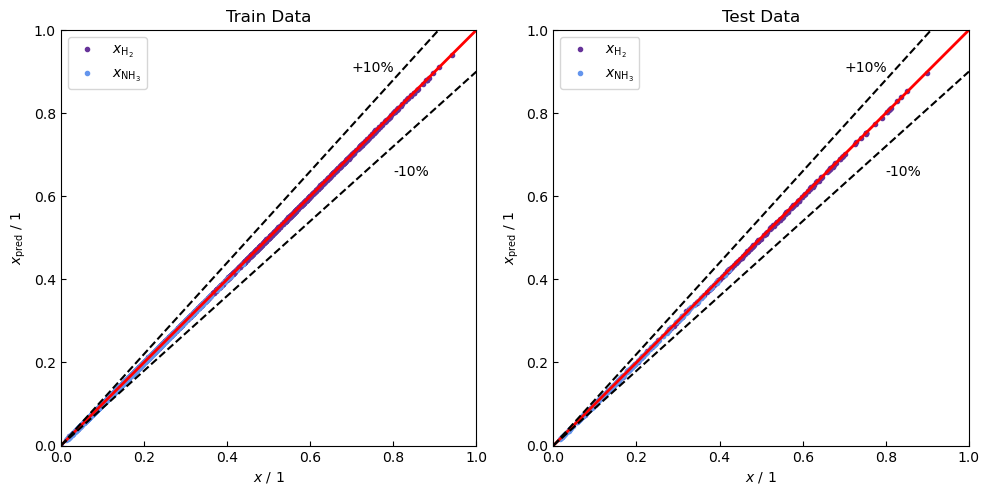

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

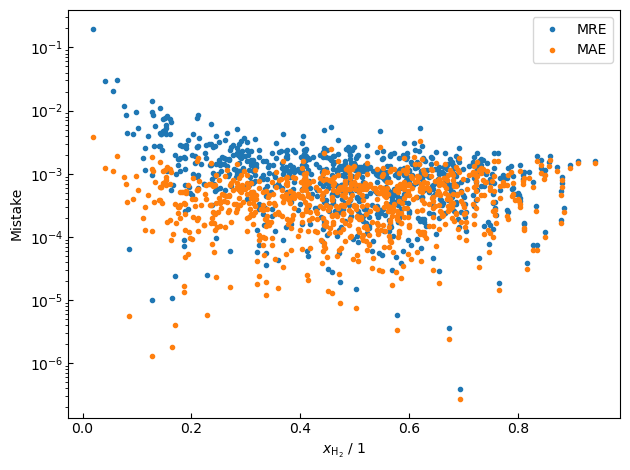

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

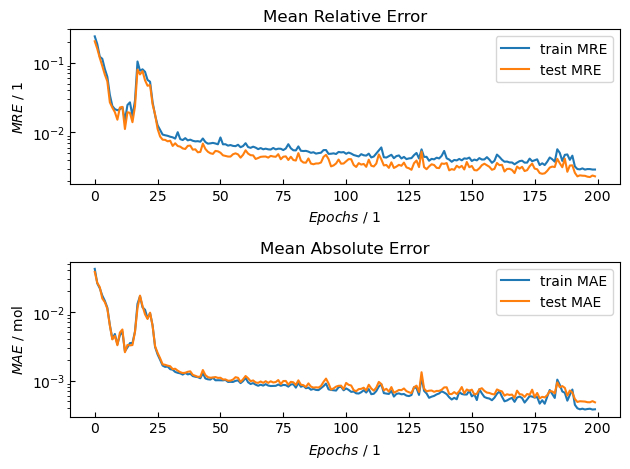

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

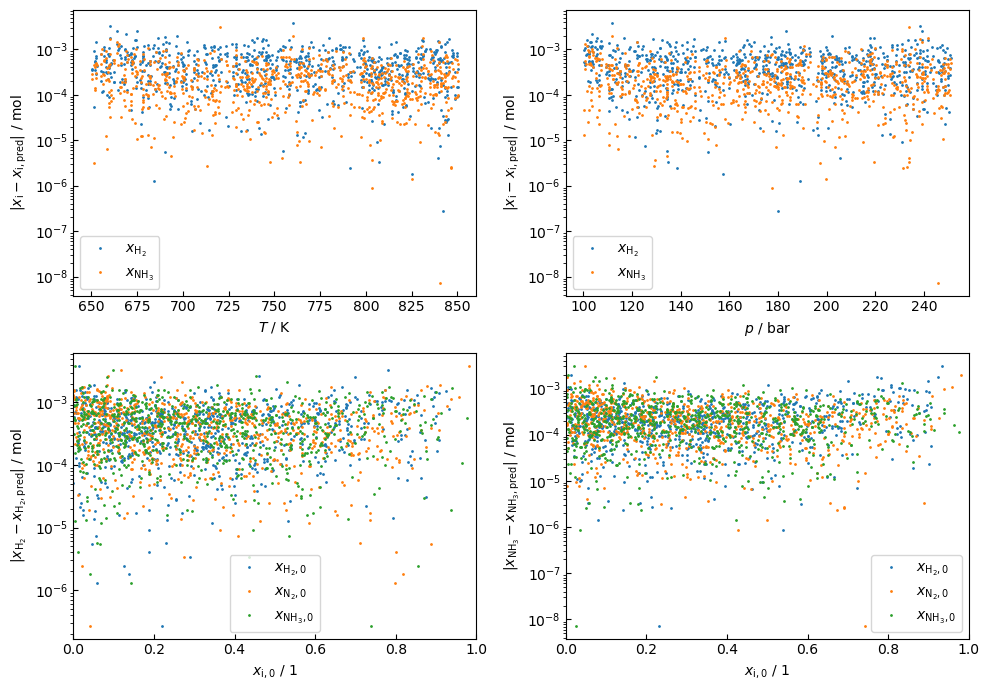

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

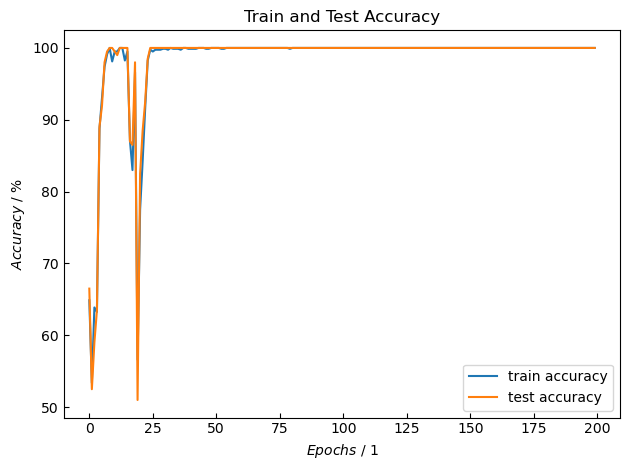

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.046875 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 6.4755e-01,  1.5108e+00,  1.1375e+00, -1.3260e+00,  2.3893e-01],
        [ 1.1433e+00, -5.1337e-01,  5.8081e-01, -1.2671e+00,  7.2509e-01],
        [-1.3654e+00,  1.7777e-01,  5.5504e-01, -1.0302e+00,  5.0820e-01],
        [ 1.0918e+00,  1.3515e-01,  6.2630e-01, -8.8850e-01,  2.9348e-01],
        [ 8.9255e-01,  1.3409e+00, -1.2877e+00,  7.3924e-01,  5.0819e-01],
        [-1.6133e+00, -2.8756e-01, -1.3274e+00,  1.4611e+00, -1.9068e-01],
        [ 1.1866e+00,  5.4906e-01, -1.0935e+00,  6.7918e-01,  3.7893e-01],
        [-9.9083e-01, -1.5584e+00,  1.0047e+00, -1.6559e-01, -8.1676e-01],
        [-1.2439e+00,  6.7573e-01, -7.3094e-01, -1.0059e+00,  1.7455e+00],
        [-1.1089e+00,  1.5590e+00, -5.5346e-01, -3.2697e-01,  8.7735e-01],
        [ 2.9756e-02, -4.7609e-01,  1.4656e+00, -6.6606e-01, -7.5752e-01],
        [-8.5368e-01, -4.5273e-01,  5.5285e-01,  6.0480e-01, -1.1607e+00],
        [ 1.3878e+00,  1.3683e+00,  6.1124e-01,  3.1491e-01, -9.2172e-01],
        [-1.7457e+00,  1.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 3.3367e-01, -1.7009e-02,  4.2128e-01, -2.6736e-02,  3.2807e-01],
         [ 2.6668e-01, -3.1480e-01, -3.6937e-01, -1.2538e-01, -1.5416e-01],
         [-2.2511e-01, -5.9299e-02, -8.0008e-02, -1.0257e-01,  1.7916e-01],
         [-1.5811e-01,  1.3346e-01, -2.6010e-01, -1.3157e-01, -3.2888e-01],
         [-4.7899e-02,  3.5749e-01, -1.0031e-01,  4.0534e-01, -1.8433e-01],
         [ 5.4894e-02,  8.2744e-04, -9.0113e-02, -9.4180e-02, -2.5824e-01],
         [-7.3559e-02,  8.5549e-02, -3.3833e-01,  2.9094e-02, -3.4265e-01],
         [ 3.2306e-01, -1.6609e-01,  3.0281e-01, -3.8074e-01,  1.1299e-01],
         [ 3.4233e-01, -3.9961e-01, -1.9234e-01,  4.1390e-02,  1.6895e-01],
         [-1.7359e-01, -3.5385e-01, -3.0042e-01, -2.0595e-03, -1.6246e-01],
         [ 2.3907e-01,  1.9542e-02,  1.5646e-01,  3.1640e-01, -3.8971e-02],
         [ 1.0710e-01, -2.5904e-04, -2.6267e-01,  1.3156e-01,  2.0524e-02],
         [ 5.6348e-02, -6.5290e-02,  1.7352e-01,  3.7404e-01, -8.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.3477, 0.4491, 0.4706, 0.6810, 0.0225],
        [0.0679, 0.5766, 0.0655, 0.5462, 0.1532]])
tensor([[-0.1652, -0.2591],
        [-0.2818,  0.0213]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-6.5761e-01, -1.5771e+00,  1.5039e+00, -3.1490e-01, -1.1540e+00],
        [-1.4645e+00, -9.3645e-01,  8.3984e-01, -7.5968e-01, -4.7756e-02],
        [-1.7468e+00, -1.6659e+00,  1.1990e-01,  7.4597e-01, -8.8010e-01],
        [-1.9498e-01,  1.3053e+00, -2.0781e-01,  1.2658e+00, -1.0898e+00],
        [ 8.2184e-01, -5.6419e-01, -1.2145e+00,  7.5507e-01,  4.2018e-01],
        [ 7.3043e-01,  1.8449e-01, -8.4743e-01,  1.5447e+00, -7.4714e-01],
        [-3.0125e-01, -1.6028e+00, -5.5705e-01,  1.3713e+00, -8.5485e-01],
        [ 1.3808e-01, -7.5407e-01,  6.6335e-01, -1.2862e+00,  6.6355e-01],
        [-1.0305e+00, -1.4174e+00,  4.7175e-01,  1.7148e-03, -4.6472e-01],
        [-1.7009e+00, -1.6729e+00, -1.0707e+00,  1.8015e+00, -7.9052e-01],
        [-1.0546e+00, -1.1501e+00,  2.1388e+00, -9.5560e-01, -1.1223e+00],
        [-5.9908e-01,  1.3275e+00,  2.5851e+00, -1.1915e+00, -1.3192e+00],
        [ 7.1903e-01, -5.0247e-01, -1.3108e+00,  2.8471e-01,  9.9541e-01],
        [-1.6306e+00, -7.

#### Histogramme Verteilung von $xi$ und $x{_i}$

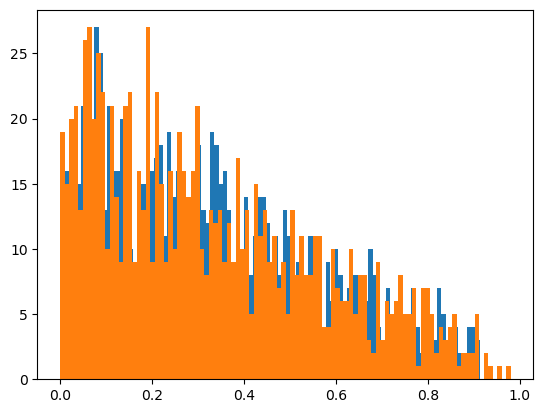

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_024.pth')
# np.savez('data/models/params_005_024.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)